In [1]:
import pickle
import os
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
warnings.simplefilter('ignore')
from platform import python_version
print(python_version())

3.9.2


# Read Inter-Subject Results

In [2]:
resultsDict = {}
for file in os.listdir('./outputs/classification/inter-subject'):
    infile = open('./outputs/classification/inter-subject/' + file, 'rb')
    resultsDict['{}'.format(file)] = pickle.load(infile)
    infile.close()

## Mean Metrics Across all Runs

In [3]:
all_reports_df = pd.DataFrame(columns=['fold', 'window_length', 'feature', 'model', 'electricPanel', 'hoist', 'ladder', 'lift', 'overhead', 'push', 'sit', 'stand', 'type', 'walk'])
for key in resultsDict.keys():
    truePredY = resultsDict[key]['TruePredY']
    reports = classification_report(truePredY['True'], truePredY['Predicted'], output_dict=True)
    reports_df = pd.DataFrame(reports)
#     reports_df.loc['support'] = reports_df.loc['support'].astype(int).astype(str)
    reports_df = reports_df.drop(columns=['macro avg', 'weighted avg'], index='support')
    reports_df['fold'] = key[4]
    if '320' in key:
        reports_df['window_length'] = 10
    elif '128' in key:
        reports_df['window_length'] = 4
        
    if 'FrequencyAll_' in key:
        reports_df['feature'] = 'Frequency'
    elif 'Time_' in key:
        reports_df['feature'] = 'Time'
    elif 'TimeFrequency_' in key:
        reports_df['feature'] = 'Time Frequency'
        
    if 'KNN' in key:
        reports_df['model'] = 'k-NN'
    elif 'SVC' in key:
        reports_df['model'] = 'SVM'
    elif 'RandomForest' in key:
        reports_df['model'] = 'RF'
        
    all_reports_df = pd.concat([all_reports_df, reports_df], axis=0)
all_reports_df = all_reports_df.reset_index().rename(columns={'index':'measure', 'accuracy': 'overall_accuracy'})
mean_df = all_reports_df.groupby(['window_length', 'feature', 'model', 'measure']).mean().reset_index()
mean_df['overall_accuracy_stdev'] = all_reports_df.groupby(['window_length', 'feature', 'model', 'measure']).std()['overall_accuracy'].values
mean_df = mean_df.round(decimals=2)
mean_df.to_csv('outputs/tables/inter-subject_mean_metrics.csv')
# mean_df

# Factors and Overall Accuracy

In [4]:
columns = ['test_set', 'window_len', 'feature_set', 'classifier', 'overall_accuracy']
accuracy_df = pd.DataFrame(columns=columns)

for key in resultsDict.keys():
    tmp_str_split = key[:-7].split('_')
    test_set = tmp_str_split[0][-1]
    feature = tmp_str_split[1]
    classifier = tmp_str_split[2]
    window_length = tmp_str_split[3]
    
    Y_true_pred = resultsDict[key]['TruePredY']
    overall_accuracy = accuracy_score(Y_true_pred['True'], Y_true_pred['Predicted'])
    
    accuracy_df = accuracy_df.append({'test_set': test_set, 'window_len': window_length, 'feature_set': feature, 'classifier': classifier, 'overall_accuracy': overall_accuracy},
                                     ignore_index=True)
# accuracy_df

# Two-Way ANOVA (Classifiers & Features) and Tukey's HSD

In [5]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

## ANOVA (10 sec)

In [6]:
accuracy_10sec_df = accuracy_df[accuracy_df['window_len']=='320']

model = ols('overall_accuracy ~ C(classifier) + C(feature_set) + C(classifier):C(feature_set)', data=accuracy_10sec_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table.to_csv('outputs/tables/ANOVA/10secANOVA.csv')
anova_table

,sum_sq,df,F,PR(>F)
C(classifier),0.007783,2.0,6.035505,5.489673e-03
C(feature_set),0.035423,2.0,27.470017,5.699713e-08
C(classifier):C(feature_set),0.004962,4.0,1.923973,1.275482e-01
Residual,0.023211,36.0,NaN,NaN


## Tukey Features (10 sec)

In [7]:
m_comp = pairwise_tukeyhsd(endog=accuracy_10sec_df['overall_accuracy'], groups=accuracy_10sec_df['feature_set'], alpha=0.05)
tukey_df = pd.DataFrame(data=m_comp._results_table.data[1:], columns = m_comp._results_table.data[0])
tukey_df.to_csv('outputs/tables/ANOVA/10secTukeyFeatures.csv')
tukey_df

,group1,group2,meandiff,p-adj,lower,upper,reject
0,FrequencyAll,Time,-0.0251,0.0599,-0.0511,0.0009,False
1,FrequencyAll,TimeFrequency,0.0429,0.0010,0.0169,0.0688,True
2,Time,TimeFrequency,0.0680,0.0010,0.0420,0.0939,True


## Tukey Classifiers (10 sec)

In [8]:
m_comp = pairwise_tukeyhsd(endog=accuracy_10sec_df['overall_accuracy'], groups=accuracy_10sec_df['classifier'], alpha=0.05)
tukey_df = pd.DataFrame(data=m_comp._results_table.data[1:], columns = m_comp._results_table.data[0])
tukey_df.to_csv('outputs/tables/ANOVA/10secTukeyClassifier.csv')
tukey_df

,group1,group2,meandiff,p-adj,lower,upper,reject
0,KNN,RandomForest,0.023,0.2493,-0.0115,0.0575,False
1,KNN,SVC,0.031,0.0857,-0.0035,0.0656,False
2,RandomForest,SVC,0.008,0.8239,-0.0265,0.0426,False


## ANOVA (4 sec)

In [9]:
accuracy_4sec_df = accuracy_df[accuracy_df['window_len']=='128']

model = ols('overall_accuracy ~ C(classifier) + C(feature_set) + C(classifier):C(feature_set)', data=accuracy_4sec_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table.to_csv('outputs/tables/ANOVA/4secANOVA.csv')
anova_table

,sum_sq,df,F,PR(>F)
C(classifier),0.006253,2.0,4.713828,1.519424e-02
C(feature_set),0.033149,2.0,24.988528,1.565160e-07
C(classifier):C(feature_set),0.002337,4.0,0.880840,4.850895e-01
Residual,0.023879,36.0,NaN,NaN


## Tukey Features (4 sec)

In [10]:
m_comp = pairwise_tukeyhsd(endog=accuracy_4sec_df['overall_accuracy'], groups=accuracy_4sec_df['feature_set'], alpha=0.05)
tukey_df = pd.DataFrame(data=m_comp._results_table.data[1:], columns = m_comp._results_table.data[0])
tukey_df.to_csv('outputs/tables/ANOVA/4secTukeyFeatures.csv')
tukey_df

,group1,group2,meandiff,p-adj,lower,upper,reject
0,FrequencyAll,Time,-0.0050,0.8639,-0.0297,0.0196,False
1,FrequencyAll,TimeFrequency,0.0549,0.0010,0.0302,0.0796,True
2,Time,TimeFrequency,0.0599,0.0010,0.0353,0.0846,True


## Tukey Classifiers (4 sec)

In [11]:
m_comp = pairwise_tukeyhsd(endog=accuracy_4sec_df['overall_accuracy'], groups=accuracy_4sec_df['classifier'], alpha=0.05)
tukey_df = pd.DataFrame(data=m_comp._results_table.data[1:], columns = m_comp._results_table.data[0])
tukey_df.to_csv('outputs/tables/ANOVA/4secTukeyClassifier.csv')
tukey_df

,group1,group2,meandiff,p-adj,lower,upper,reject
0,KNN,RandomForest,0.0089,0.7776,-0.0245,0.0422,False
1,KNN,SVC,0.0282,0.1114,-0.0051,0.0616,False
2,RandomForest,SVC,0.0194,0.3457,-0.0140,0.0527,False


# Box Plots: Effect of Features on Overall Accuracy's

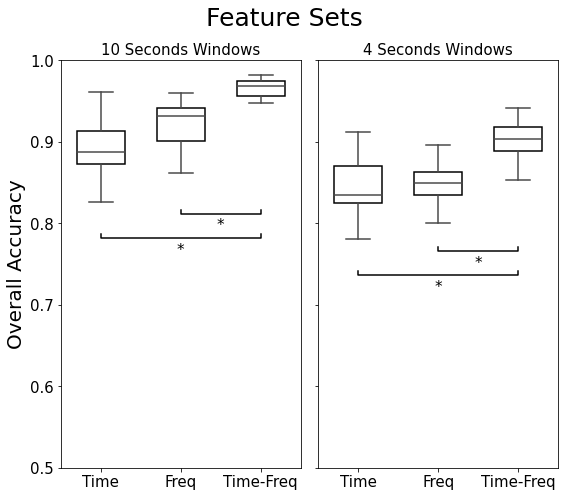

In [12]:
order = ['Time', 'FrequencyAll', 'TimeFrequency']
f, ax = plt.subplots(1, 2, figsize=(8, 7), sharey=True)
sns.boxplot(x='feature_set', y='overall_accuracy', data=accuracy_10sec_df, ax=ax[0], palette='Set1',
                   order=order, showfliers=False, width=0.6)

ax[0].set_title('10 Seconds Windows', fontsize=15)
ax[0].set_ylabel('Overall Accuracy', fontsize=20)
ax[0].set_xlabel('')
ax[0].set_ylim([0.5, 1])
ax[0].set_xticklabels(['Time', 'Freq', 'Time-Freq'], fontsize=15)
ax[0].tick_params(axis='y', which='major', labelsize=15)

for i,box in enumerate(ax[0].artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')
    
x1, x2 = 1, 2
y, h, col = accuracy_10sec_df['overall_accuracy'].min() - 0.01, -0.005, 'k'
ax[0].plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax[0].text((x1+x2)*.5, y+2*h, "*", ha='center', va='top', color=col, fontsize=15)

x1, x2 = 0, 2
y, h, col = accuracy_10sec_df['overall_accuracy'].min() - 0.04, -0.005, 'k'
ax[0].plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax[0].text((x1+x2)*.5, y+2*h, "*", ha='center', va='top', color=col, fontsize=15)


sns.boxplot(x='feature_set', y='overall_accuracy', data=accuracy_4sec_df, ax=ax[1], palette='Set1', order=order, showfliers=False, width=0.6)
ax[1].set_title('4 Seconds Windows', fontsize=15)
ax[1].set_xticklabels(['Time', 'Freq', 'Time-Freq'], fontsize=15)
ax[1].set_xlabel('')
ax[1].set_ylabel('')

for i,box in enumerate(ax[1].artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')
    
x1, x2 = 1, 2
y, h, col = accuracy_4sec_df['overall_accuracy'].min() - 0.01, -0.005, 'k'
ax[1].plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax[1].text((x1+x2)*.5, y+2*h, "*", ha='center', va='top', color=col, fontsize=15)

x1, x2 = 0, 2
y, h, col = accuracy_4sec_df['overall_accuracy'].min() - 0.04, -0.005, 'k'
ax[1].plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax[1].text((x1+x2)*.5, y+2*h, "*", ha='center', va='top', color=col, fontsize=15)


f.suptitle('Feature Sets', fontsize=25)
f.tight_layout()

f.savefig('outputs/figures/boxPlots.png')
plt.show()